In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
import numpy as np
import time
import scipy.signal as ss
import scipy
from scipy.optimize import curve_fit

import marvin
from marvin.tools import Maps, Cube
from marvin import config
from marvin.tools import RSS
import marvin.utils.plot.map as mapplot

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import FLRW
from astropy import units as u

import photutils
from photutils import geometry


config.setRelease('DR17')
marvin.config.mode = 'remote'
marvin.config.download = True
plt.style.use('seaborn') ####### Oder lieber einen anderen Stil?
fsize = 18

data_marco = fits.open('2kpc_aperture_AGN_catalog.fits')
data_table = Table.read(data_marco, hdu=1)

hdul = fits.open('data\MASCOT.fits')

cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308)

manga_id=  hdul[1].data['MaNGA ID']
manga_id_list = list(manga_id)

galaxies_list = ['7991-6104','9499-6104','8720-1901']

from datetime import datetime

current_dateTime = datetime.now()
today = str(current_dateTime.day)+'.'+str(current_dateTime.month)+'.'+str(current_dateTime.year)

print(today)

9.12.2022


In [3]:
# Ich empfehle beim einfachen Durchgehen das Ausschalten der Warunungen 
import warnings
warnings.filterwarnings('ignore')

In [5]:
def BPT_Plot_OIII(id):
    maps = Maps(id)
    ha   = maps['emline_gflux_ha_6564']
    hb   = maps['emline_gflux_hb_4862']
    oiii = maps['emline_gflux_oiii_5008']
    nii  = maps['emline_gflux_nii_6585']
    
    ha [ha.snr < 5] = 0
    hb [hb.snr < 5] = 0
    oiii [oiii.snr < 5] = 0
    nii [nii.snr < 5] = 0   


    log_oiii_hb = np.log10(oiii.value / hb.value)
    log_nii_ha = np.log10(nii.value / ha.value) 
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))
    x1 = np.linspace(-1.5, 0.46, 100)
    x2 = np.linspace(-1.5, 0.09, 100)
    x3 = np.linspace(-0.18, 1, 100)

    def ke01(x):
            return(0.61/(x-0.47)+1.19)
    def ka03(x):
        return(0.61/(x-0.1)+1.3)    
    def schawinski_line(x):
        return(1.05*x+0.45)

    inv_bool  = np.ones(ha.shape, dtype='bool')
    agn_bool  = np.zeros(ha.shape, dtype='bool') 
    sf_bool   = np.zeros(ha.shape, dtype='bool')
    comp_bool = np.zeros(ha.shape, dtype='bool')
    agn_bool_extra = np.zeros(ha.shape, dtype='bool')

    inv_bool  [np.where(np.isnan(log_oiii_hb))] = False
    inv_bool  [np.where(np.isnan(log_nii_ha))] = False
    inv_bool  [np.where(np.isfinite(log_oiii_hb) == False)] = False
    inv_bool  [np.where(np.isfinite(log_nii_ha) == False)] = False

    agn_bool  [np.where((log_oiii_hb >=  ke01(log_nii_ha)) & inv_bool) and np.where((log_nii_ha > 0.47) & inv_bool)] = True
    agn_bool  [np.where((log_oiii_hb >=  ke01(log_nii_ha)) & inv_bool)] = True
    comp_bool [np.where((log_oiii_hb >=  ka03(log_nii_ha)) & (log_oiii_hb <=  ke01(log_nii_ha)) & inv_bool
                     & (log_nii_ha <= 0.47))] = True
    comp_bool [np.where((log_oiii_hb <=  ke01(log_nii_ha)) & (0.47 >= log_nii_ha) &
                        ( log_nii_ha >= 0.1) & inv_bool)] = True
    sf_bool   [np.where((log_oiii_hb <  ka03(log_nii_ha)) & (log_oiii_hb <  ke01(log_nii_ha)) & (log_nii_ha < 0.1)
                        & inv_bool)] = True
    
    seyfert_bool = agn_bool.copy()
    seyfert_bool [np.where((log_oiii_hb <=  schawinski_line(log_nii_ha)) & inv_bool  )] = False
    liner_bool = agn_bool.copy()
    liner_bool [np.where(seyfert_bool == True)] = False
    
    
    ##### Classsification ############
    seyfert_oiii_hb = log_oiii_hb[seyfert_bool] 
    seyfert_nii_ha  = log_nii_ha[seyfert_bool]  
    
    liner_oiii_hb = log_oiii_hb  [liner_bool]
    liner_nii_ha = log_nii_ha [liner_bool]

    star_formation_oiii_hb = log_oiii_hb[sf_bool]
    star_formation_nii_ha = log_nii_ha[sf_bool]

    compository_oiii_hb = log_oiii_hb[comp_bool]
    compository_nii_ha = log_nii_ha[comp_bool]

    ax1.plot(x1, ke01(x1), '--', color='black') 
    ax1.plot(x2, ka03(x2), 'C1') 
    ax1.plot(x3, schawinski_line(x3), 'purple', linestyle='-.')

    ax1.text(-0.06, -0.5, 'ke01', rotation=-70, fontsize=fsize, color='black')
    ax1.text(-0.7, 0.2, 'ka03', rotation=-45, fontsize=fsize, color='C1')
    ax1.text(0.25, 0.8, 'schawinski line', rotation=34, fontsize=fsize, color='purple')

    ax1.scatter(seyfert_nii_ha, seyfert_oiii_hb, color = 'red'  , label = 'Seyfert' )
    ax1.scatter(liner_nii_ha, liner_oiii_hb, color = 'orange'  , label = 'Liner' )
    ax1.scatter(star_formation_nii_ha, star_formation_oiii_hb, color = 'blue'  , label = 'star formation')
    ax1.scatter(compository_nii_ha, compository_oiii_hb, color = 'green'  , label = 'compository')

    ax1.set_xlabel(r'Log10([NII]/H$\alpha)$', fontsize=fsize)
    ax1.set_ylabel(r'Log10([OIII]/H$\beta)$', fontsize=fsize)
    ax1.set_title ('BPT-Plot '+ str(id), fontsize=fsize)
    ax1.legend(loc= 'lower left', fontsize=fsize)
    ax1.set_ylim(-1.5, 1.6)
    ax1.set_xlim(-1, 1)
    
    data = seyfert_bool * 4 + liner_bool*3  + comp_bool*2 +  sf_bool 

    cmap   = colors.ListedColormap([ 'black','blue','green', 'orange', 'red'])
    norm   = colors.BoundaryNorm([-0.5,0.5,1.5, 2.5, 3.5, 4.5], cmap.N)
    
    cmap_cbar = colors.ListedColormap(['blue','green', 'orange', 'red'])
    norm_cbar   = colors.BoundaryNorm([1.5, 2.5, 3.5, 4.5], cmap_cbar.N)

    im = ax2.imshow(data, cmap=cmap, norm = norm, origin='lower')
    cbar = plt.colorbar(im, ax = ax2, ticks=[1, 2, 3, 4],  cmap=cmap_cbar, norm = norm_cbar)
    cbar.ax.set_yticklabels(['SF', 'COMP','Liner', 'Seyfert']) 
    cbar.ax.tick_params(labelsize=fsize)
    ax2.set_title("BPT-Map " + str(id), fontsize=fsize,  weight='bold')
    ax2.set_xlabel('Spaxel', fontsize=fsize)
    ax2.set_ylabel('Spaxel', fontsize=fsize)

    plt.tight_layout()
    ##plt.savefig('BPT_PLOT_8940-12702.png')
    plt.show()
    

    print(np.sum(agn_bool)/np.sum(inv_bool))

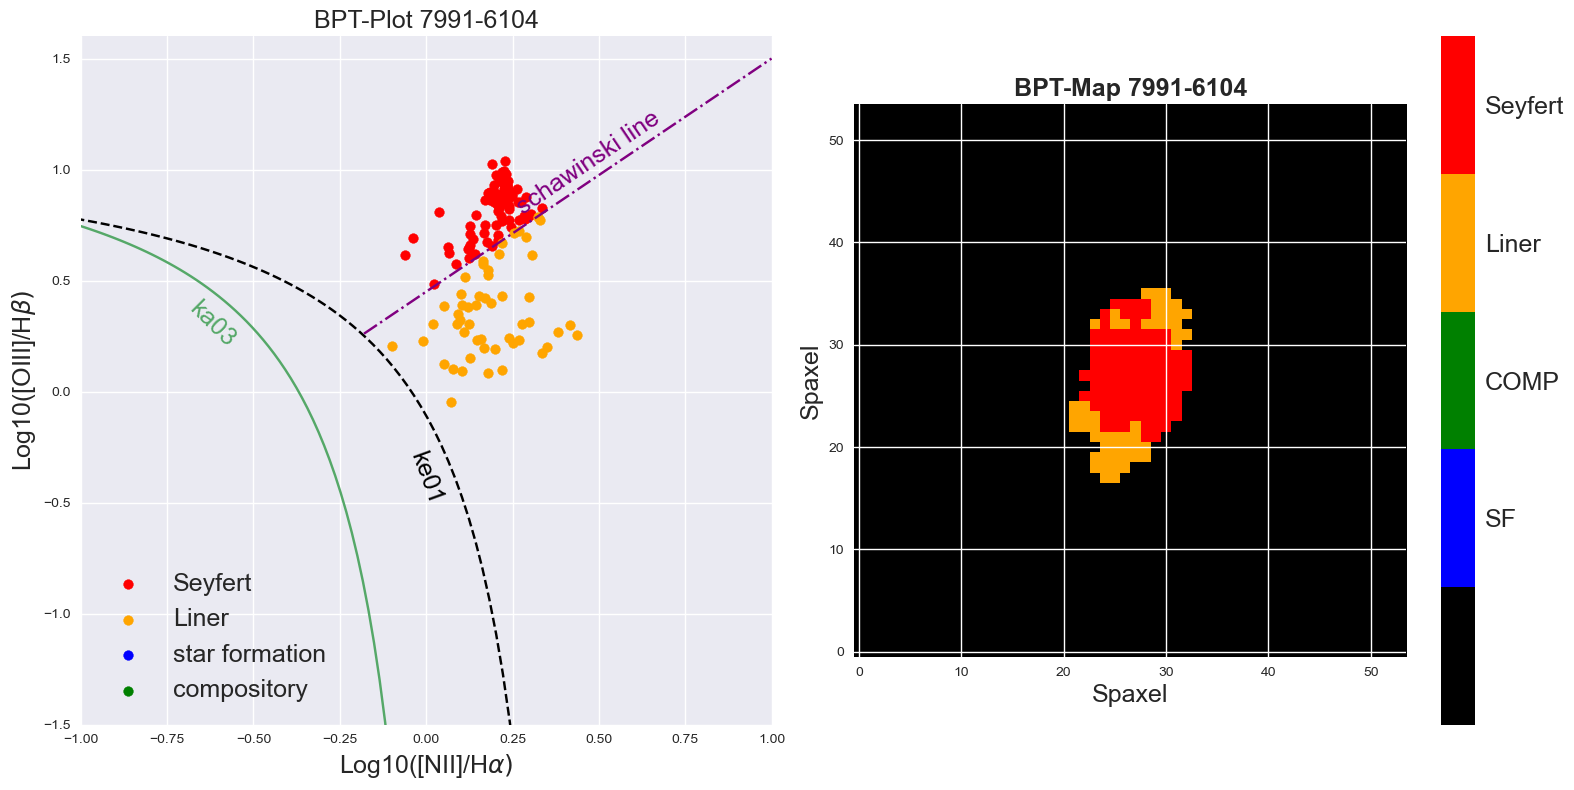

1.0


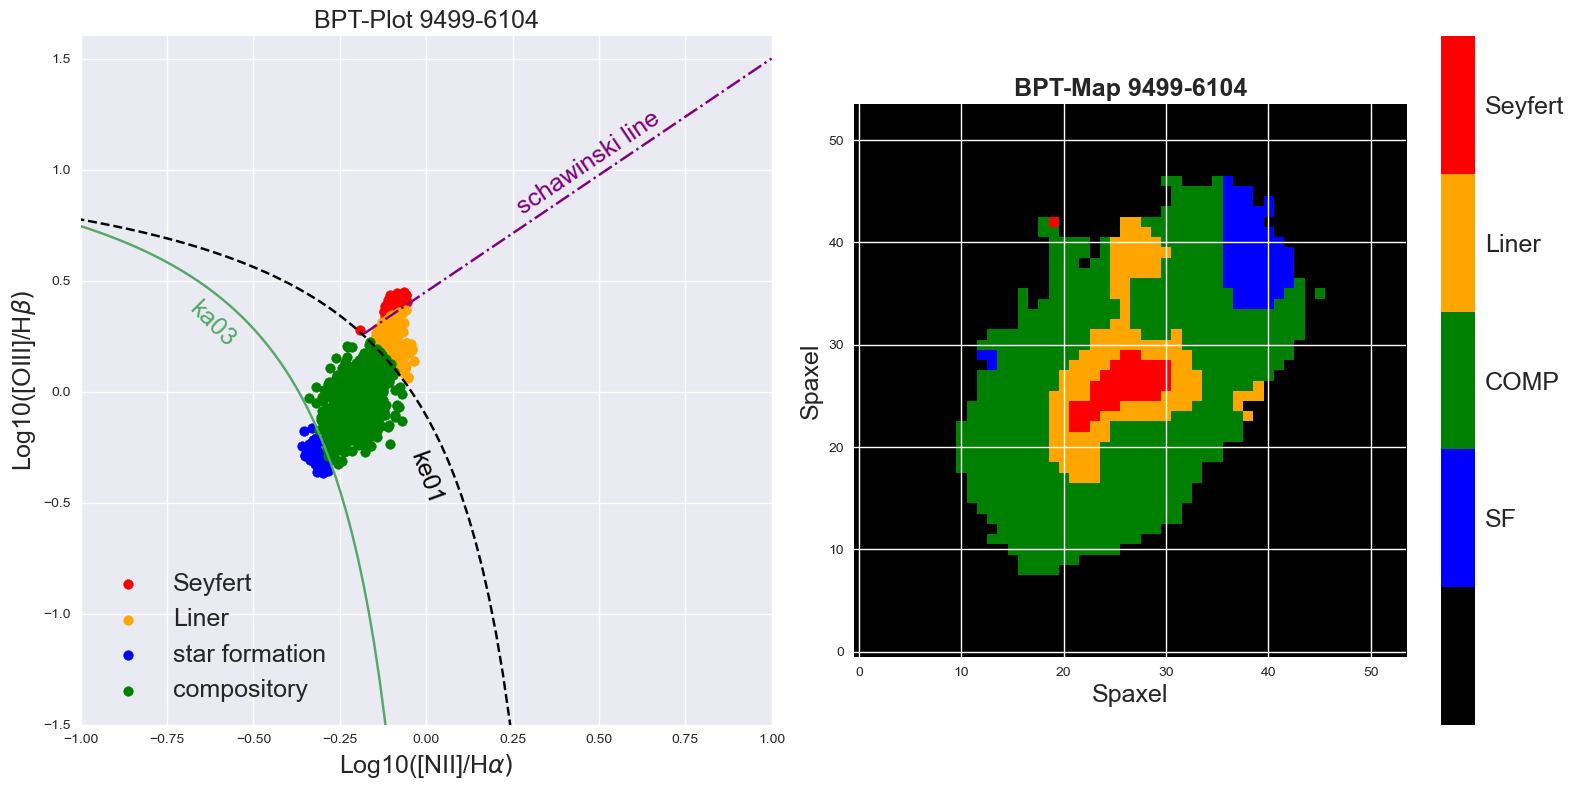

0.20971563981042654


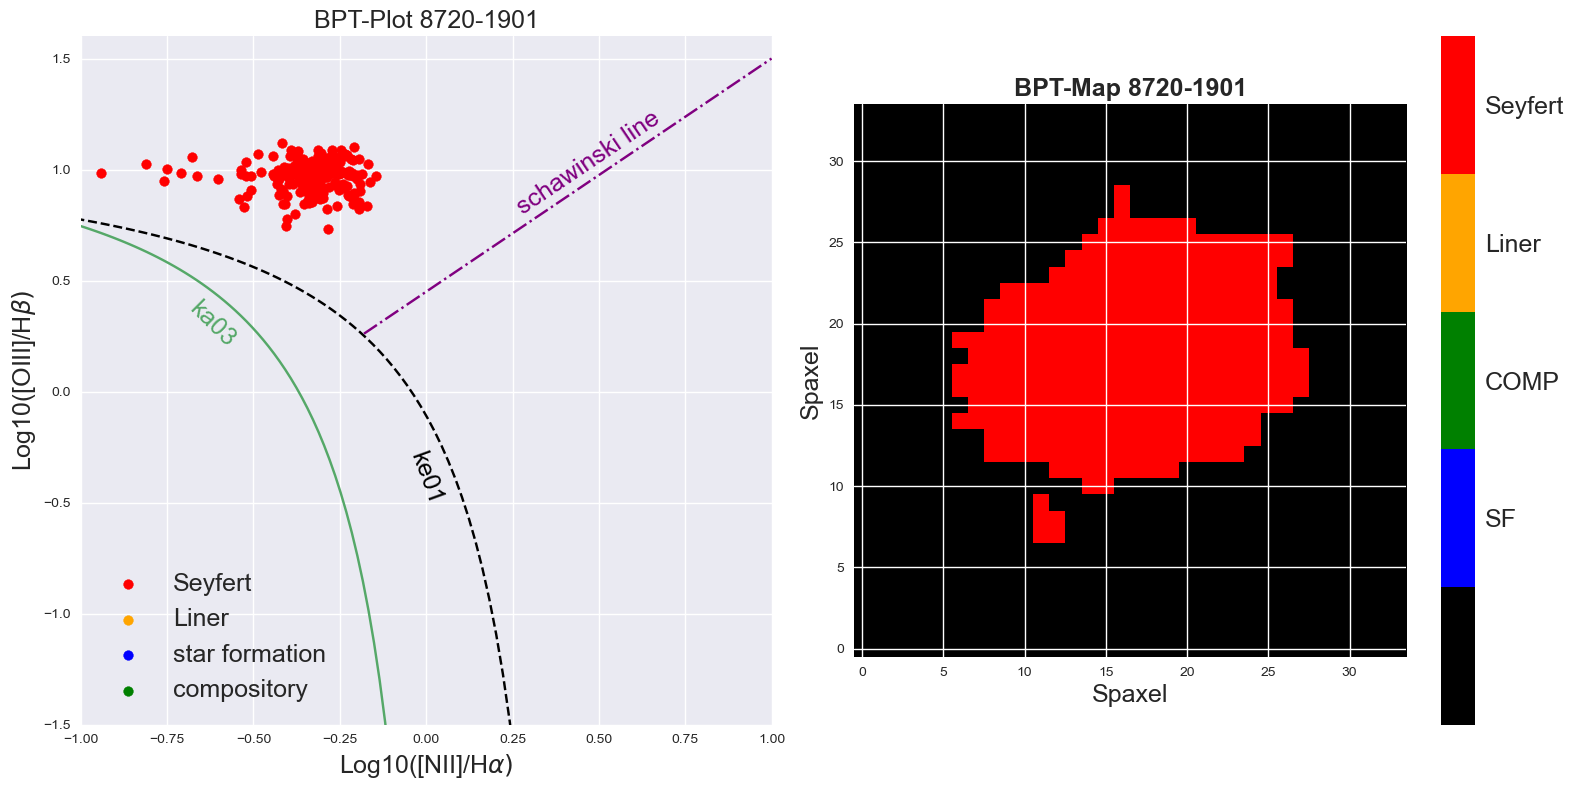

1.0


In [53]:
BPT_Plot_OIII(galaxies_list[0])
BPT_Plot_OIII(galaxies_list[1])
BPT_Plot_OIII(galaxies_list[2])

In [59]:
agn_list=[]
ha_ew= 0

data_string = "{} {} {} {} {} {} {} {} {} \n" 
data_items = ["mangaid", "ra", "dec", "z", "FWHM", "EW_Ha",'BPT_X','BPT_Y',"AGN"]

current_dateTime = datetime.now()
today = str(current_dateTime.day)+'.'+str(current_dateTime.month)+'.'+str(current_dateTime.year)

f_agn = open('data/AGNs-'+today+'.dat', 'w')
f_agn.write(data_string.format(*data_items))

f_not_agn = open('data/All_BPT-'+today+'.dat', 'w')
f_not_agn.write(data_string.format(*data_items))

for mangaid in manga_id_list:
    if mangaid != '8138-12703':
        maps = Maps(mangaid)
        ha   = maps['emline_gflux_ha_6564']
        hb   = maps['emline_gflux_hb_4862']
        oiii = maps['emline_gflux_oiii_5008']
        nii  = maps['emline_gflux_nii_6585']        

        ha [ha.snr < 5] = 0
        hb [hb.snr < 5] = 0
        oiii [oiii.snr < 5] = 0
        nii [nii.snr < 5] = 0   

        z = maps.dapall['z']
        ra = maps.dapall['ifura']
        dec = maps.dapall['ifudec']
        FWHM = np.float(maps.header['GFWHM'])
        is_agn = 0            

        log_oiii_hb = np.log10(oiii.value / hb.value)
        log_nii_ha = np.log10(nii.value / ha.value) 

        def ke01(x):
                return(0.61/(x-0.47)+1.19)
        def ka03(x):
            return(0.61/(x-0.1)+1.3)    
        def schawinski_line(x):
            return(1.05*x+0.45)

        inv_bool  = np.ones(ha.shape, dtype='bool')
        agn_bool  = np.zeros(ha.shape, dtype='bool') 
        sf_bool   = np.zeros(ha.shape, dtype='bool')
        comp_bool = np.zeros(ha.shape, dtype='bool')
        agn_bool_extra = np.zeros(ha.shape, dtype='bool')

        inv_bool  [np.where(np.isnan(log_oiii_hb))] = False
        inv_bool  [np.where(np.isnan(log_nii_ha))] = False
        inv_bool  [np.where(np.isfinite(log_oiii_hb) == False)] = False
        inv_bool  [np.where(np.isfinite(log_nii_ha) == False)] = False

        agn_bool  [np.where((log_oiii_hb >=  ke01(log_nii_ha)) & inv_bool) 
                   and np.where((log_nii_ha > 0.47) & inv_bool)] = True
        agn_bool  [np.where((log_oiii_hb >=  ke01(log_nii_ha)) & inv_bool)] = True

        agn_ratio = np.sum(agn_bool)/np.sum(inv_bool)

        BPT_X =  np.ma.median( log_nii_ha [np.where((np.isnan(log_nii_ha) == False ) & np.isfinite(log_nii_ha))] )
        BPT_Y =  np.ma.median( log_oiii_hb [np.where((np.isnan(log_oiii_hb) == False ) & np.isfinite(log_oiii_hb))] )
        EW_Ha = np.mean(ha.value[agn_bool & (ha.value > 3)])

        if agn_ratio >= 2/3:   
            if EW_Ha >= ha_ew:
                agn_list.append(mangaid)
                is_agn = 1
        if is_agn:
            f_agn.write(data_string.format(mangaid, ra, dec, z, FWHM, EW_Ha,BPT_X,BPT_Y, is_agn))
        else:
            f_not_agn.write(data_string.format(mangaid, ra, dec, z, FWHM, EW_Ha,BPT_X,BPT_Y, is_agn))
f_agn.close() 
f_not_agn.close() 

In [63]:
f_agn

mangaid,ra,dec,z,FWHM,EW_Ha,BPT_X,BPT_Y,AGN
str10,float64,float64,float64,float64,float64,float64,float64,int32
7815-6104,319.193,11.0437,0.0806967,2.4163,24.9774018875502,-0.3340141717910742,0.603867419180652,1
8249-3704,137.875,45.4683,0.0268253,2.56176,7.316820412371135,-0.06562440683253881,0.5844065936803338,1
8595-3703,221.438,51.5808,0.0296268,2.45207,6.223796741573034,0.002127025060021327,0.09024296543207838,1
8715-3702,119.921,50.84,0.0543641,2.62048,54.68898933035714,0.07655383569681275,1.1528771930054855,1
9000-1901,171.401,54.3826,0.0206863,2.39113,60.45975263157895,0.009680273057303103,0.13554496173220765,1
9487-3702,123.331,46.1472,0.053819,2.42887,10.457284199999998,0.025135991108886487,0.7508614591224259,1
9497-12705,118.074,19.5951,0.117007,2.31869,61.44067967213114,-0.2849834723400146,0.7809120261565423,1
9500-1901,131.725,25.3701,0.0507934,2.28755,19.74035021276596,-0.09045677710029551,0.6259426306147804,1


In [62]:
f_all

mangaid,ra,dec,z,FWHM,EW_Ha,BPT_X,BPT_Y,AGN
str10,float64,float64,float64,float64,float64,float64,float64,int32
10001-3702,132.913,57.1074,0.0256063,2.78204,nan,-0.21780700290570593,-0.4795408353696689,0
7443-12703,229.526,42.7458,0.0402719,2.6072,10.680094225352113,-0.25724553285325163,-0.009176017240784772,0
7443-12704,232.461,42.629,0.0187385,2.59597,nan,-0.5008374278027933,-0.20969489315064738,0
7815-3702,317.903,11.4969,0.0293823,2.64475,nan,-0.3529036437316958,-0.4857967854668467,0
7958-6101,257.384,34.427,0.0238889,2.4418,nan,-0.31492004804160767,-0.5555640439289187,0
7968-3701,322.213,-1.07012,0.0515439,2.57742,nan,-0.42681413101675475,-0.578029952525899,0
7990-1902,264.522,57.1182,0.0300503,2.59671,nan,-0.30664736948724614,-0.4325632917679809,0
7990-3703,262.099,57.5454,0.0285483,2.47536,nan,-0.7102703634721115,0.1766824253037676,0
7990-6104,261.608,58.5889,0.026199,2.4997,nan,-0.5186178406962854,-0.20897583521724433,0


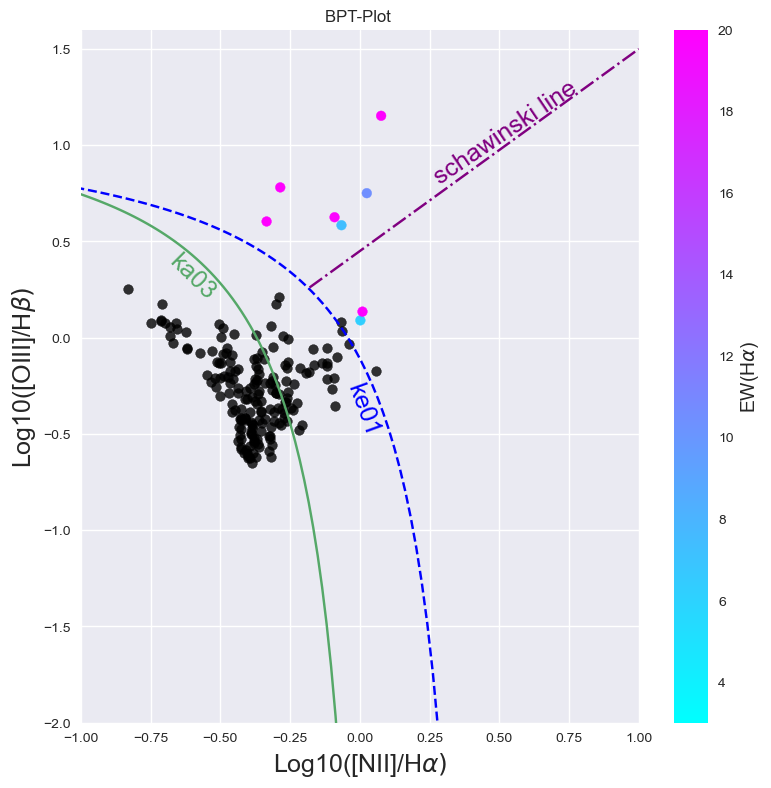

In [6]:
f_agn = Table.read('./data/AGNs-8.12.2022.dat', format='ascii')
f_all = Table.read('./data/All_BPT-8.12.2022.dat', format='ascii')

plt.figure(figsize=(9,9))

plt.scatter(f_all['BPT_X'], f_all['BPT_Y'], color='black', alpha=0.8)
subfig2 = plt.scatter(f_agn['BPT_X'], f_agn['BPT_Y'], c=f_agn['EW_Ha'], label="AGN",cmap='cool', vmin=3, vmax=20)

cbar = plt.colorbar(subfig2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(r'EW(H$\alpha$)', fontsize=14)

x1 = np.linspace(-1.5, 0.46, 100)
x2 = np.linspace(-1.5, 0.09, 100)
x3 = np.linspace(-0.18, 1, 100)        

def ke01(x):
    return(0.61/(x-0.47)+1.19)
def ka03(x):
    return(0.61/(x-0.1)+1.3)    
def schawinski_line(x):
    return(1.05*x+0.45)



plt.plot(x1, ke01(x1), '--', color='blue') 
plt.plot(x2, ka03(x2), 'C1') 
plt.plot(x3, schawinski_line(x3), 'purple', linestyle='-.')

plt.text(-0.06, -0.5, 'ke01', rotation=-70, fontsize=fsize, color='blue')
plt.text(-0.7, 0.2, 'ka03', rotation=-45, fontsize=fsize, color='C1')
plt.text(0.25, 0.8, 'schawinski line', rotation=34, fontsize=fsize, color='purple')

plt.xlabel(r'Log10([NII]/H$\alpha)$', fontsize=fsize)
plt.ylabel(r'Log10([OIII]/H$\beta)$', fontsize=fsize)
plt.title ('BPT-Plot ')
#plt.legend(loc= 'lower left', fontsize=fsize)
plt.ylim(-2, 1.6)
plt.xlim(-1, 1)
plt.savefig("BPT_Übersichtsplot.pdf", format="pdf", bbox_inches="tight")

plt.show()